# Detect number from images

Train a model to detect the number in player shirts

## Load packages

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
import cv2
import os
import imutils
from google.colab.patches import cv2_imshow
import pickle

## Load paths

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
drive_path = 'drive/MyDrive/Colab Notebooks/numbers_detection'
train_path = f'{drive_path}/train'
train_label_file = f'{train_path}/train_pos_label.txt'

test_path = f'{drive_path}/test'
test_label_file = f'{test_path}/test_pos_label.txt'

## Load data

images and respective number bounding boxes

In [13]:
with open(drive_path+'/data_bbox.pickle', 'rb') as handle:
  [trainImages, trainLabels, trainTargets, trainFilenames, testImages, testLabels, testTargets, testFilenames] = pickle.load(handle)

### Example of a sample

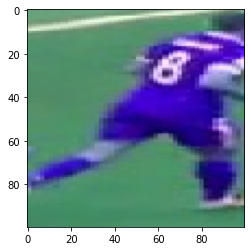

In [18]:
# image
plt.imshow(trainImages[0])

In [19]:
# number position
trainTargets[0]

array([0.6397569 , 0.34333333, 0.67569447, 0.18666665], dtype=float32)

## Model Architecture

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = True

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)



58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
opt = Adam(lr=1e-4)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=10,
    verbose=1)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.save(drive_path+'/number_detection.h5')

## Model performance

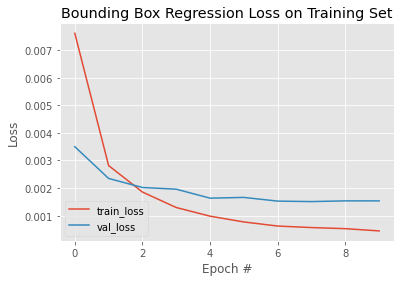

In [ ]:
# plot the model training history
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

## Example of predictions

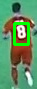

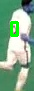

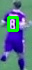

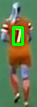

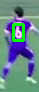

In [ ]:
for imagePath in testFilenames[10:20]:
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  preds = model.predict(image)
  preds_bbox = preds[0]

  (startX, startY, endX, endY) = preds_bbox

  # load the input image (in OpenCV format), resize it such that it
  # fits on our screen, and grab its dimensions
  image = cv2.imread(imagePath)
  image = imutils.resize(image)
  (h, w) = image.shape[:2]

  
  # scale the predicted bounding box coordinates based on the image
  # dimensions
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)

  # draw the predicted bounding box on the image
  cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)

  # show the output image
  cv2_imshow(image)